In [3]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt 
from scipy.special import expit as logistic

from jupyterthemes import jtplot
jtplot.style()

In [5]:
df = pd.read_csv(
    '/Users/albertwakhloo/Downloads/rethinking statistics/Rethinking/Data/reedfrogs.csv', sep = ',')

print(df.columns)
df.head(5).append(df.tail(5))

Index(['density', 'pred', 'size', 'surv', 'propsurv'], dtype='object')


,density,pred,size,surv,propsurv
0,10,no,big,9,0.900000
1,10,no,big,10,1.000000
2,10,no,big,7,0.700000
3,10,no,big,10,1.000000
4,10,no,small,9,0.900000
43,35,pred,big,14,0.400000
44,35,pred,small,22,0.628571
45,35,pred,small,12,0.342857
46,35,pred,small,31,0.885714
47,35,pred,small,17,0.485714


In [17]:
df.pred = pd.Categorical(df.pred)
df['predator'] = df.pred.cat.codes
df['size'] = pd.Categorical(df['size'])
df['sizer'] = df['size'].cat.codes
df.head(3)
#print(df.predator) ; print(df.sizer)

,density,pred,size,surv,propsurv,predator,sizer
0,10,no,big,9,0.9,0,0
1,10,no,big,10,1.0,0,0
2,10,no,big,7,0.7,0,0


In [18]:
tank = np.arange(df.shape[0])
size = df.sizer.values
predator = df.predator.values

tank

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

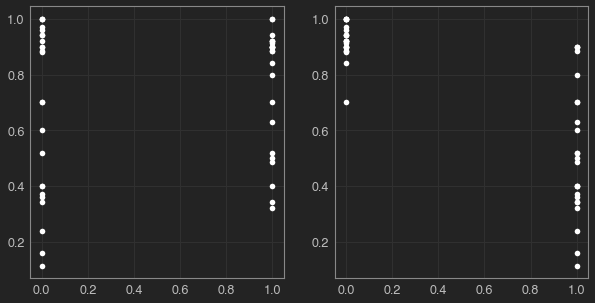

In [19]:
_, ax = plt.subplots(1, 2, figsize = (10, 5)) 
ax[0].plot(df.sizer, df.propsurv, 'o', color = 'w') 
ax[1].plot(df.predator, df.propsurv, 'o', color = 'w')

In [21]:
varnames = ['alpha_bar', 'sigma_alpha', 'b_pred', 'b_size']

In [22]:
with pm.Model() as frog_man : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_pred = pm.Normal('b_pred', mu = .5, sigma = 1) 
    b_size = pm.Normal('b_size', mu = 0, sigma = 3) 
    
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    
    p = pm.math.invlogit(alpha_tank[tank] + b_pred * predator + b_size * size)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = varnames)

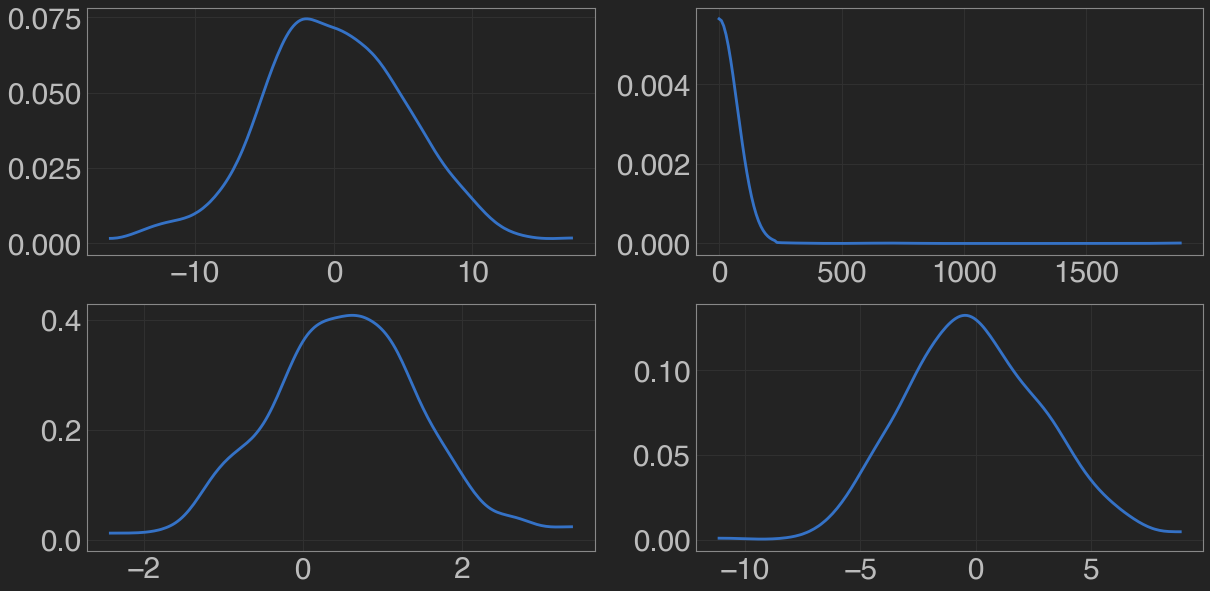

In [23]:
__, ax = plt.subplots(2, 2, figsize = (20, 10))

for i, axis in zip(varnames, ax.flat) : 
    az.plot_kde(prior[i], ax = axis)

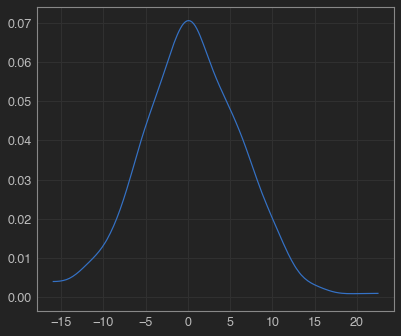

In [24]:
pr = 1
sz = 1
az.plot_kde(prior['alpha_bar'] + prior['b_pred'] * pr + prior['b_size'] * sz)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_tank, b_size, b_pred, sigma_alpha, alpha_bar]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:15<00:00, 515.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b7b45f8>,
      dtype=object)

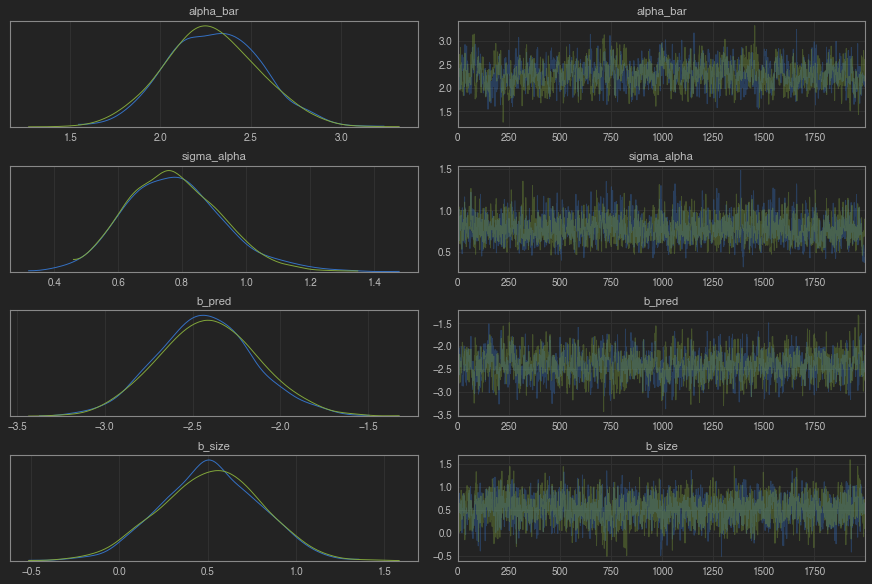

In [25]:
with frog_man : 
    trace_1 = pm.sample(2000, tune = 2000) 
    
az.plot_trace(trace_1, var_names = varnames)

In [26]:
az.summary(trace_1, round_to = 2, var_names = varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,2.29,0.26,1.80,2.76,0.01,0.01,644.67,644.67,646.28,1775.85,1.0
sigma_alpha,0.78,0.15,0.50,1.05,0.00,0.00,1350.60,1350.60,1261.86,1498.27,1.0
b_pred,-2.42,0.28,-2.94,-1.87,0.01,0.01,827.11,827.11,826.81,1870.93,1.0
b_size,0.51,0.29,-0.02,1.02,0.01,0.01,1448.74,1448.74,1445.39,2022.54,1.0


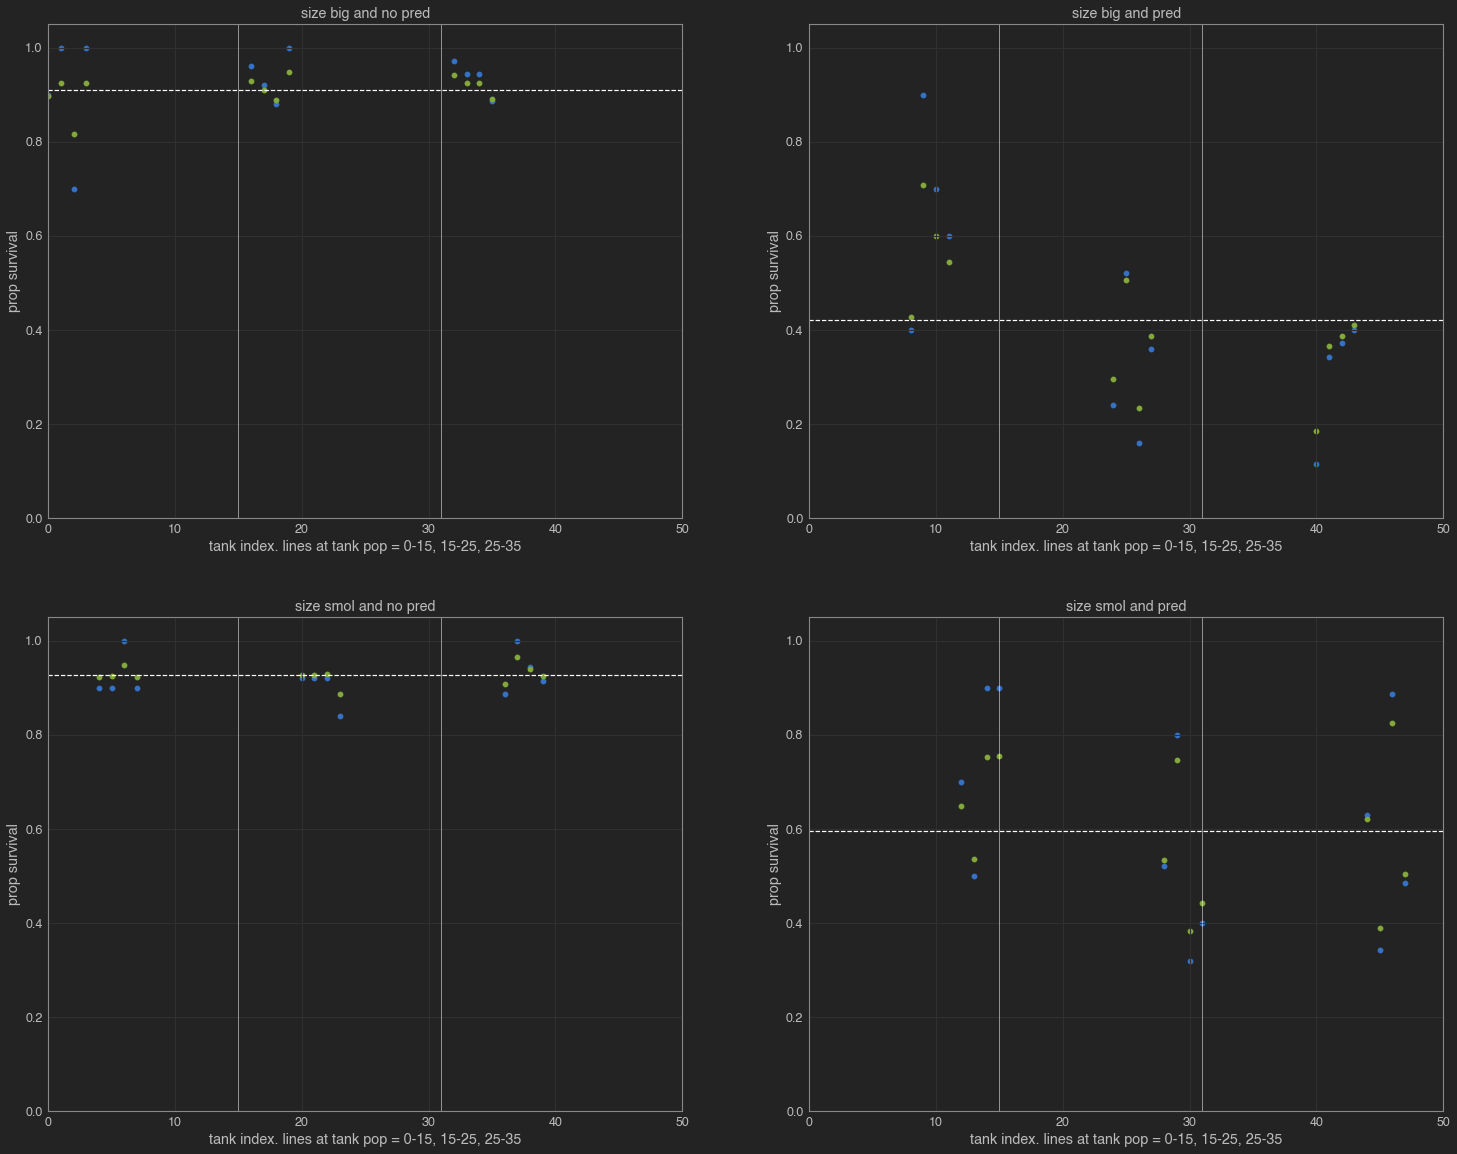

In [28]:
__, axs = plt.subplots(2, 2, figsize = (25 , 20))
size_pred_seq = [[0,0], [0,1], [1,0], [1,1]]

tanks = np.arange(df.shape[0])
trace_df = pm.trace_to_dataframe(trace_1) 

for s, ax in zip(size_pred_seq, axs.flat):
    '''
    loop over each axis and pred/size combination. grab relevant data rows and push thru trace
    take the mean and plot. add in lines to separate btwn between tank sizes 
    '''
    data_rows = df.loc[(df['sizer'] == s[0]) & (df['predator'] == s[1])]
    ax.scatter(data_rows.index, data_rows.propsurv.values)
    trace_tank_index = (data_rows.index + 3) #offset by three since the trace has other params before it gets to the tanks
    mu_raw = logistic(trace_df.iloc[:, trace_tank_index].values + (trace_df['b_size']*s[0])[:, None] \
                      + (trace_df['b_pred'] * s[1])[:, None])
    mu = mu_raw.mean(0) 
    ax.scatter(data_rows.index.values, mu)
    ax.hlines(mu.mean(), -1, 50, color = 'w', linestyles='--')
    lines = [df.loc[df['density'] == 10].index.values.max(),
             df.loc[df['density'] == 25].index.values.max()]
    ax.vlines(lines, -1, 2, color = 'w', lw = .5)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 1.05)
    title = []
    if s[0] == 1 :
        title.append('size smol ')
    else : 
        title.append('size big ')
    if s[1] == 0 : 
        title.append('and no pred')
    else :
        title.append('and pred')
    ax.set_title(title[0] + title[1])
    ax.set_xlabel('tank index. lines at tank pop = 0-15, 15-25, 25-35')
    ax.set_ylabel('prop survival')

###### note how nicely the model shrinks the crazy low tank on bottom left–it in size big and no pred graph. It 'sees'  that it was a fluke to have such a condition with such a low surv rate. It recognizes that size doesn't matter so much. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_tank, b_pred, sigma_alpha, alpha_bar]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:13<00:00, 572.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arvi

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,2.532,0.240,2.107,3.008,0.010,0.007,535.0,534.0,537.0,1471.0,1.01
sigma_alpha,0.826,0.145,0.583,1.121,0.004,0.003,1125.0,1125.0,1123.0,1748.0,1.00
b_pred,-2.393,0.304,-2.963,-1.843,0.014,0.010,503.0,500.0,502.0,1207.0,1.01


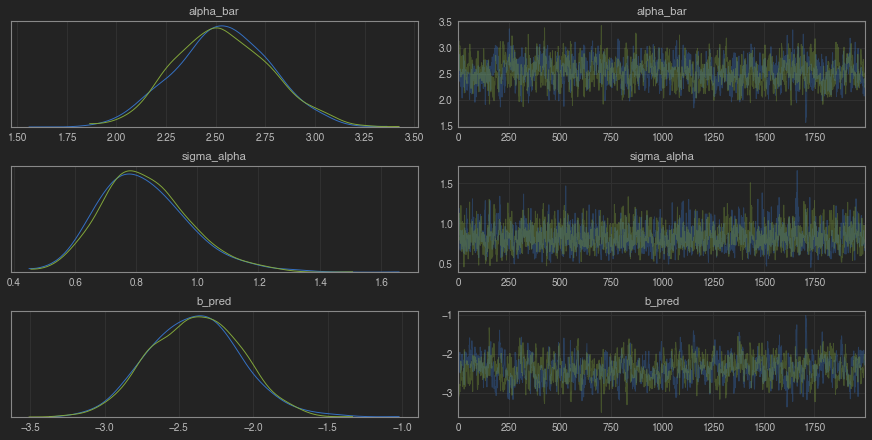

In [29]:
with pm.Model() as frog_man_pred : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_pred = pm.Normal('b_pred', mu = .5, sigma = 1) 
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    p = pm.math.invlogit(alpha_tank[tank] + b_pred * predator)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred'])
    trace_2 = pm.sample(2000, tune = 2000)
az.plot_trace(trace_2, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred']) 
az.summary(trace_2, var_names = ['alpha_bar', 'sigma_alpha', 'b_pred'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_tank, b_size, sigma_alpha, alpha_bar]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:15<00:00, 526.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arvi

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_bar,1.145,0.353,0.498,1.831,0.011,0.007,1125.0,1125.0,1127.0,1778.0,1.0
sigma_alpha,1.622,0.215,1.244,2.040,0.004,0.003,2801.0,2801.0,2804.0,3171.0,1.0
b_size,0.474,0.464,-0.385,1.337,0.017,0.012,752.0,752.0,755.0,1261.0,1.0


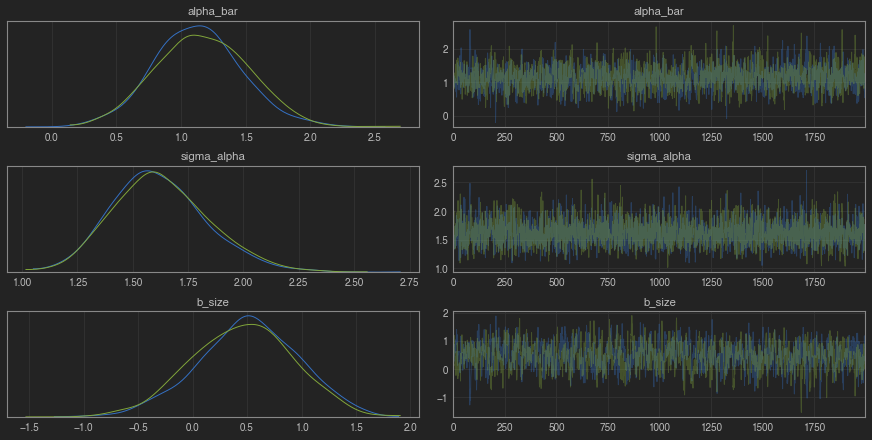

In [30]:
with pm.Model() as frog_man_size : 
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', 1.)
    b_size = pm.Normal('b_size', mu = .5, sigma = 1) 
    alpha_tank = pm.Normal('alpha_tank', mu = alpha_bar, sigma = sigma_alpha, shape = len(tank))
    p = pm.math.invlogit(alpha_tank[tank] +  b_size * size)
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    prior = pm.sample_prior_predictive(1000, var_names = ['alpha_bar', 'sigma_alpha', 'b_size'])
    trace_3 = pm.sample(2000, tune = 2000)
az.plot_trace(trace_3, var_names = ['alpha_bar', 'sigma_alpha', 'b_size']) 
az.summary(trace_3, var_names = ['alpha_bar', 'sigma_alpha', 'b_size'])

In [31]:
comparison = az.compare({'bigg model' : trace_1,
                        'pred model' : trace_2, 
                        'size model' : trace_3})

comparison

/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
pred model,0,197.938,18.8035,0,0.507797,8.40234,0,True,deviance
bigg model,1,200.205,19.175,2.26759,0.183706,8.72688,2.38669,True,deviance
size model,2,200.297,20.9713,2.35995,0.308497,6.96609,5.93895,True,deviance


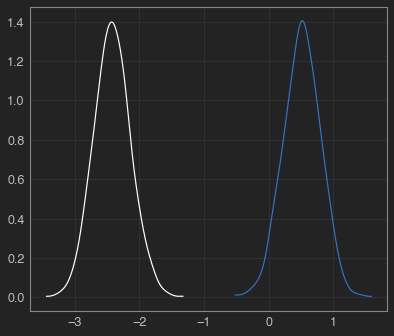

In [32]:
az.plot_kde(trace_1['b_size'])
az.plot_kde(trace_1['b_pred'], plot_kwargs = {'color' : 'w'})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f4ed080>],
      dtype=object)

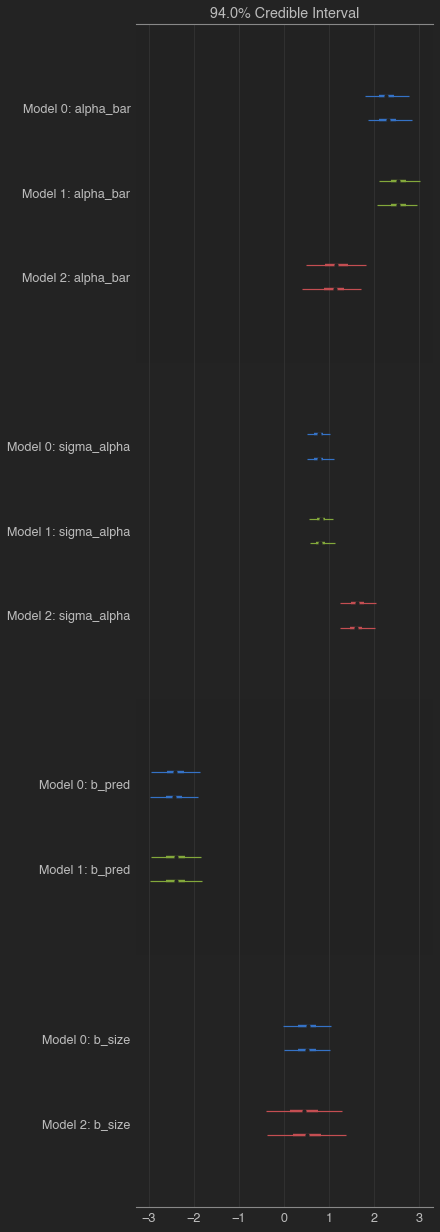

In [33]:
traces = [trace_1, trace_2, trace_3]
az.plot_forest(traces, var_names = varnames)

### these results tend to indicate that the size of the tank isn't really a relevant factor  but predator pop is: in particular, pay attention to the similarity in WAIC weights in the comparison plot, the similarity/dissimilarity between grand means in the forest plot, the tiny  difference in the graphs of the first model with varying size values, and the tendency for b_size to stay at zero in the models. Moreover, peep the kde plot of b_pred and b_size. Big  difference in relative importance

In [34]:
with pm.Model() as frogman_cauchy : 
    b = pm.HalfCauchy('b', 1)
    alpha_bar = pm.Normal('alpha_bar', mu = 0, sigma = 1)
    alpha = pm.Cauchy('alpha', alpha = alpha_bar, beta = b, shape = len(tank))
    p = pm.math.invlogit(alpha[tank])
    surv = pm.Binomial('surv', n = df.density, p = p, observed = df.surv)
    trace_4 = pm.sample(2000, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, alpha_bar, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [02:04<00:00, 64.24draws/s] 
The acceptance probability does not match the target. It is 0.9849366546595901, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a8bdb00>,
      dtype=object)

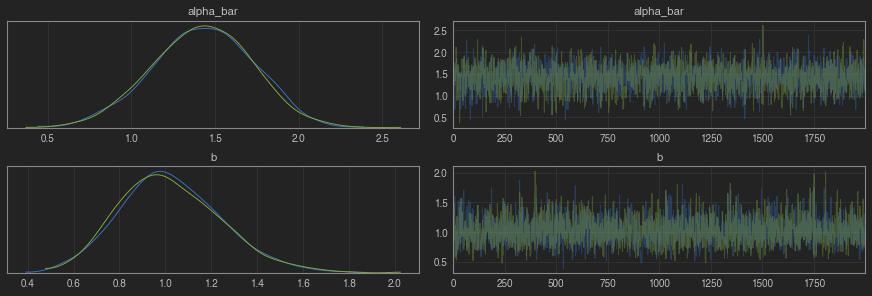

In [35]:
az.plot_trace(trace_4, var_names = ['alpha_bar', 'b'])

/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 425.78it/s]


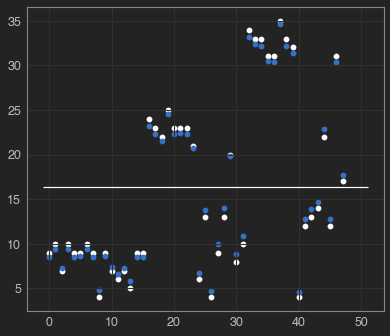

In [36]:
post = pm.sample_posterior_predictive(trace_4, 1000, frogman_cauchy)

_, ax2 = plt.subplots() 
ax2.scatter(df.index, df.surv, color = 'w')
ax2.scatter(df.index, post['surv'].mean(0) )
ax2.hlines(df.surv.mean(), -1, 51, color = 'w')

#so for some reason this seems to be shrinking way too little... probably the Cauchy prior

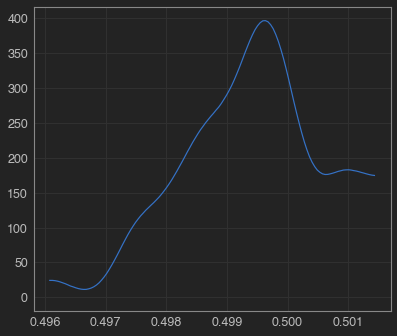

In [37]:
with frogman_cauchy : 
    priors = pm.sample_prior_predictive(100000)
    
az.plot_kde(logistic(priors['alpha']).mean(0))

##### so it looks like the wide uncertainty in the cauchy prior means that the model doesn't effectively regularize leading to overfitting

In [38]:
nu_compare = comparison = az.compare({'bigg model' : trace_1,
                        'pred model' : trace_2, 
                        'size model' : trace_3, 
                        'cauchy model' : trace_4})

nu_compare

/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
pred model,0,197.938,18.8035,0,0.485488,8.39476,0,True,deviance
bigg model,1,200.205,19.175,2.26759,0.176011,8.8797,2.38669,True,deviance
size model,2,200.297,20.9713,2.35995,0.242534,7.23978,5.93895,True,deviance
cauchy model,3,203.29,23.0944,5.3522,0.0959664,8.47333,6.87498,True,deviance
